In [1]:
%matplotlib inline
import numpy as np
import pickle
import pandas as pd
import mxnet as mx
import wget
import time
import os.path
import math
import matplotlib.pyplot as plt
import logging

In [2]:
ctx = mx.gpu(0)

AZ_ACC = "amazonsentimenik"
AZ_CONTAINER = "textclassificationdatasets"
ALPHABET = list("abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"/\\|_@#$%^&*~`+ =<>()[]{}")
FEATURE_LEN = 1014
BATCH_SIZE = 128
EPOCHS = 10
DATA_SHAPE = (BATCH_SIZE, 1, FEATURE_LEN, 1)
NOUTPUT = 2  # good or bad

SD = 0.05  # std for gaussian distribution
INITY = mx.init.Normal(sigma=SD)
LR = 0.01
MOMENTUM = 0.9
WDECAY = 0.00001

In [3]:
# logging
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='vd_cnn_amazon.log', mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)

In [4]:
def download_file(url):
    # Create file-name
    local_filename = url.split('/')[-1]
    if os.path.isfile(local_filename):
        pass
        # print("The file %s already exist in the current directory\n" % local_filename)
    else:
        # Download
        print("downloading ...\n")
        wget.download(url)
        print('\nsaved data')

In [5]:
def load_data_frame(infile, shuffle = False):
    print("processing data frame: %s" % infile)
    # Get data from windows blob
    download_file('https://%s.blob.core.windows.net/%s/%s' % (AZ_ACC, AZ_CONTAINER, infile))
    
    # load data into dataframe
    df = pd.read_csv(infile,
                     header=None,
                     names=['sentiment', 'summary', 'text'])
    # Shuffle
    if shuffle:
        df = df.sample(frac=1).reset_index(drop=True)
        
    # concat summary, review; trim to 1014 char; reverse; lower
    df['rev'] = df.apply(lambda x: "%s %s" % (x['summary'], x['text']), axis=1)
    df.rev = df.rev.str[:FEATURE_LEN].str[::-1].str.lower()
    
    # store class as nparray
    df.sentiment -= 1
    clsses = df.sentiment.unique()
    print("Classes: ", clsses)
    assert len(clsses) == NOUTPUT
    y_split = np.asarray(df.sentiment, dtype='int')
    # drop columns
    df.drop(['text', 'summary', 'sentiment'], axis=1, inplace=True)

    # Dictionary to create character vectors
    char_index = dict((c, i + 2) for i, c in enumerate(ALPHABET))
    
    print("finished processing data frame: %s" % infile)
    print("data contains %d obs" % df.shape[0])
    
    # All obs
    batch_size = df.shape[0]
    # Create encoding
    X_split = np.zeros([batch_size, 1, FEATURE_LEN, 1], dtype='int')
    
    # Main loop
    for ti, tx in enumerate(df.rev):
        if (ti+1) % (100*1000) == 0:
            print("Processed: ", ti+1)
        chars = list(tx)
        for ci, ch in enumerate(chars):
            if ch in ALPHABET:
                #X_split[ti % batch_size][0][ci] = np.array(character_hash[ch], dtype='bool')
                X_split[ti % batch_size][0][ci] = char_index[ch]
                
    # Return as a DataBatch
    #return DataBatch(data=[mx.nd.array(X_split)],
    #                 label=[mx.nd.array(y_split[ti + 1 - batch_size:ti + 1])])
    
    return X_split, y_split

In [6]:
class k_max_pool(mx.operator.CustomOp):

    """
    https://github.com/CNevd/DeepLearning-Mxnet/blob/master/DCNN/dcnn_train.py#L15
    """

    def __init__(self, k):
        super(k_max_pool, self).__init__()
        self.k = int(k)

    def forward(self, is_train, req, in_data, out_data, aux):
        x = in_data[0].asnumpy()
        # assert(4 == len(x.shape))
        ind = np.argsort(x, axis=2)
        sorted_ind = np.sort(ind[:, :, -(self.k):, :], axis=2)
        dim0, dim1, dim2, dim3 = sorted_ind.shape
        self.indices_dim0 = np.arange(dim0).repeat(dim1 * dim2 * dim3)
        self.indices_dim1 = np.transpose(
            np.arange(dim1).repeat(dim2 * dim3).reshape((dim1 * dim2 * dim3, 1)).repeat(dim0, axis=1)).flatten()
        self.indices_dim2 = sorted_ind.flatten()
        self.indices_dim3 = np.transpose(
            np.arange(dim3).repeat(dim2).reshape((dim2 * dim3, 1)).repeat(dim0 * dim1, axis=1)).flatten()
        y = x[self.indices_dim0, self.indices_dim1, self.indices_dim2, self.indices_dim3].reshape(sorted_ind.shape)
        self.assign(out_data[0], req[0], mx.nd.array(y))

    def backward(self, req, out_grad, in_data, out_data, in_grad, aux):
        x = out_grad[0].asnumpy()
        y = in_data[0].asnumpy()
        # assert(4 == len(x.shape))
        # assert(4 == len(y.shape))
        y[:, :, :, :] = 0
        y[self.indices_dim0, self.indices_dim1, self.indices_dim2, self.indices_dim3] \
            = x.reshape([x.shape[0] * x.shape[1] * x.shape[2] * x.shape[3], ])
        self.assign(in_grad[0], req[0], mx.nd.array(y))


@mx.operator.register("k_max_pool")
class k_max_poolProp(mx.operator.CustomOpProp):
    def __init__(self, k):
        self.k = int(k)
        super(k_max_poolProp, self).__init__(True)

    def list_argument(self):
        return ['data']

    def list_outputs(self):
        return ['output']

    def infer_shape(self, in_shape):
        data_shape = in_shape[0]
        assert (len(data_shape) == 4)
        out_shape = (data_shape[0], data_shape[1], self.k, data_shape[3])
        return [data_shape], [out_shape]

    def create_operator(self, ctx, shapes, dtypes):
        return k_max_pool(self.k)

In [7]:
def create_vdcnn():
    """
    29 Convolutional Layers

    We want to increase the number of conv layers to 29 in the following structure:
    1 | 10 | 10 | 4 | 4 -> 4.6 million params

    We down-sample using convolutions with stride=2

    ToDo:
    2. Temporal batch norm vs. batch norm? -> "Temp batch norm applies same kind of regularization
    as batch norm, except that the activations in a mini-batch are jointly normalized over temporal
    instead of spatial locations"
    3. Double check that optional shortcuts are not used for the smaller nets (only for 49 conv layer one,
    as they reduce performance for 9, 17, 29 conv. layer models)
    """

    vocab_size = 69
    embedding_size = 16
    temp_kernel = (3, embedding_size)
    kernel = (3, 1)
    stride = (2, 1)
    padding = (1, 0)
    kmax = 8
    num_filters1 = 64
    num_filters2 = 128
    num_filters3 = 256
    num_filters4 = 512

    input_x = mx.sym.Variable('data')  # placeholder for input
    input_y = mx.sym.Variable('softmax_label')  # placeholder for output

    # Lookup Table 16
    embed_layer = mx.symbol.Embedding(
        data=input_x, input_dim=vocab_size, output_dim=embedding_size, name='word_embedding')
    embed_out = mx.sym.Reshape(
        data=embed_layer, shape=(BATCH_SIZE, 1, FEATURE_LEN, embedding_size))

    # Temp Conv (in: batch, 1, 1014, 16)
    conv0 = mx.symbol.Convolution(
        data=embed_out, kernel=temp_kernel, pad=padding, num_filter=num_filters1)
    act0 = mx.symbol.Activation(
        data=conv0, act_type='relu')

    # CONVOLUTION_BLOCK (1 of 4) -> 64 FILTERS
    conv11 = mx.symbol.Convolution(
        data=act0, kernel=kernel, pad=padding, num_filter=num_filters1)
    norm11 = mx.symbol.BatchNorm(
        data=conv11)
    act11 = mx.symbol.Activation(
        data=norm11, act_type='relu')
    conv12 = mx.symbol.Convolution(
        data=act11, kernel=kernel, pad=padding, num_filter=num_filters1)
    norm12 = mx.symbol.BatchNorm(
        data=conv12)
    act12 = mx.symbol.Activation(
        data=norm12, act_type='relu')
    conv21 = mx.symbol.Convolution(
        data=act12, kernel=kernel, pad=padding, num_filter=num_filters1)
    norm21 = mx.symbol.BatchNorm(
        data=conv21)
    act21 = mx.symbol.Activation(
        data=norm21, act_type='relu')
    conv22 = mx.symbol.Convolution(
        data=act21, kernel=kernel, pad=padding, num_filter=num_filters1)
    norm22 = mx.symbol.BatchNorm(
        data=conv22)
    act22 = mx.symbol.Activation(
        data=norm22, act_type='relu')

    pool1 = mx.symbol.Pooling(
        data=act22, pool_type='max', kernel=kernel, pad=padding, stride=stride)

    # CONVOLUTION_BLOCK (2 of 4) -> 128 FILTERS
    conv31 = mx.symbol.Convolution(
        data=pool1, kernel=kernel, pad=padding, num_filter=num_filters2)
    norm31 = mx.symbol.BatchNorm(
        data=conv31)
    act31 = mx.symbol.Activation(
        data=norm31, act_type='relu')
    conv32 = mx.symbol.Convolution(
        data=act31, kernel=kernel, pad=padding, num_filter=num_filters2)
    norm32 = mx.symbol.BatchNorm(
        data=conv32)
    act32 = mx.symbol.Activation(
        data=norm32, act_type='relu')
    conv41 = mx.symbol.Convolution(
        data=act32, kernel=kernel, pad=padding, num_filter=num_filters2)
    norm41 = mx.symbol.BatchNorm(
        data=conv41)
    act41 = mx.symbol.Activation(
        data=norm41, act_type='relu')
    conv42 = mx.symbol.Convolution(
        data=act41, kernel=kernel, pad=padding, num_filter=num_filters2)
    norm42 = mx.symbol.BatchNorm(
        data=conv42)
    act42 = mx.symbol.Activation(
        data=norm42, act_type='relu')

    pool2 = mx.symbol.Pooling(
        data=act42, pool_type='max', kernel=kernel, pad=padding, stride=stride)

    # CONVOLUTION_BLOCK (3 of 4) -> 256 FILTERS
    conv51 = mx.symbol.Convolution(
        data=pool2, kernel=kernel, pad=padding, num_filter=num_filters3)
    norm51 = mx.symbol.BatchNorm(
        data=conv51)
    act51 = mx.symbol.Activation(
        data=norm51, act_type='relu')
    conv52 = mx.symbol.Convolution(
        data=act51, kernel=kernel, pad=padding, num_filter=num_filters3)
    norm52 = mx.symbol.BatchNorm(
        data=conv52)
    act52 = mx.symbol.Activation(
        data=norm52, act_type='relu')
    conv61 = mx.symbol.Convolution(
        data=act52, kernel=kernel, pad=padding, num_filter=num_filters3)
    norm61 = mx.symbol.BatchNorm(
        data=conv61)
    act61 = mx.symbol.Activation(
        data=norm61, act_type='relu')
    conv62 = mx.symbol.Convolution(
        data=act61, kernel=kernel, pad=padding, num_filter=num_filters3)
    norm62 = mx.symbol.BatchNorm(
        data=conv62)
    act62 = mx.symbol.Activation(
        data=norm62, act_type='relu')

    pool3 = mx.symbol.Pooling(
        data=act62, pool_type='max', kernel=kernel, pad=padding, stride=stride)

    # CONVOLUTION_BLOCK (4 of 4) -> 512 FILTERS
    conv71 = mx.symbol.Convolution(
        data=pool3, kernel=kernel, pad=padding, num_filter=num_filters4)
    norm71 = mx.symbol.BatchNorm(
        data=conv71)
    act71 = mx.symbol.Activation(
        data=norm71, act_type='relu')
    conv72 = mx.symbol.Convolution(
        data=act71, kernel=kernel, pad=padding, num_filter=num_filters4)
    norm72 = mx.symbol.BatchNorm(
        data=conv72)
    act72 = mx.symbol.Activation(
        data=norm72, act_type='relu')
    conv81 = mx.symbol.Convolution(
        data=act72, kernel=kernel, pad=padding, num_filter=num_filters4)
    norm81 = mx.symbol.BatchNorm(
        data=conv81)
    act81 = mx.symbol.Activation(
        data=norm81, act_type='relu')
    conv82 = mx.symbol.Convolution(
        data=act81, kernel=kernel, pad=padding, num_filter=num_filters4)
    norm82 = mx.symbol.BatchNorm(
        data=conv82)
    act82 = mx.symbol.Activation(
        data=norm82, act_type='relu')

    # K-max pooling (k=8)
    pool4 = mx.symbol.Custom(
        data=act82, op_type='k_max_pool', k=kmax)

    # Flatten (dimensions * feature length * filters)
    flatten = mx.symbol.Flatten(data=pool4)

    # First fully connected
    fc1 = mx.symbol.FullyConnected(
        data=flatten, num_hidden=4096)
    act_fc1 = mx.symbol.Activation(
        data=fc1, act_type='relu')
    # Second fully connected
    fc2 = mx.symbol.FullyConnected(
        data=act_fc1, num_hidden=2048)
    act_fc2 = mx.symbol.Activation(
        data=fc2, act_type='relu')
    # Third fully connected
    fc3 = mx.symbol.FullyConnected(
        data=act_fc2, num_hidden=NOUTPUT)
    net = mx.symbol.SoftmaxOutput(
        data=fc3, label=input_y, name="softmax")

    #Debug:
    arg_shape, output_shape, aux_shape = net.infer_shape(data=(DATA_SHAPE))
    print("Arg Shape: ", arg_shape)
    print("Output Shape: ", output_shape)
    print("Aux Shape: ", aux_shape)
    print("Created network")

    return net

('Arg Shape: ', [(128L, 1L, 1014L, 1L), (69L, 16L), (64L, 1L, 3L, 16L), (64L,), (64L, 64L, 3L, 1L), (64L,), (64L,), (64L,), (64L, 64L, 3L, 1L), (64L,), (64L,), (64L,), (64L, 64L, 3L, 1L), (64L,), (64L,), (64L,), (64L, 64L, 3L, 1L), (64L,), (64L,), (64L,), (128L, 64L, 3L, 1L), (128L,), (128L,), (128L,), (128L, 128L, 3L, 1L), (128L,), (128L,), (128L,), (128L, 128L, 3L, 1L), (128L,), (128L,), (128L,), (128L, 128L, 3L, 1L), (128L,), (128L,), (128L,), (256L, 128L, 3L, 1L), (256L,), (256L,), (256L,), (256L, 256L, 3L, 1L), (256L,), (256L,), (256L,), (256L, 256L, 3L, 1L), (256L,), (256L,), (256L,), (256L, 256L, 3L, 1L), (256L,), (256L,), (256L,), (512L, 256L, 3L, 1L), (512L,), (512L,), (512L,), (512L, 512L, 3L, 1L), (512L,), (512L,), (512L,), (512L, 512L, 3L, 1L), (512L,), (512L,), (512L,), (512L, 512L, 3L, 1L), (512L,), (512L,), (512L,), (4096L, 4096L), (4096L,), (2048L, 4096L), (2048L,), (2L, 2048L), (2L,), (128L,)])
('Output Shape: ', [(128L, 2L)])
('Aux Shape: ', [(64L,), (64L,), (64L,), (

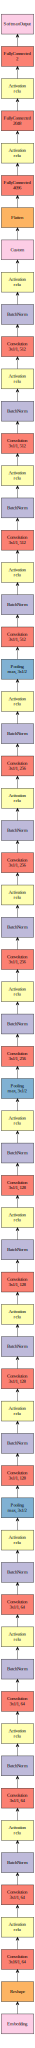

In [8]:
# Visualise symbol (for crepe)
cnn = create_vdcnn()

a = mx.viz.plot_network(cnn)
a.render('Model')
a

In [9]:
train_x, train_y = load_data_frame('amazon_review_polarity_train.csv')

processing data frame: amazon_review_polarity_train.csv
('Classes: ', array([1, 0], dtype=int64))
finished processing data frame: amazon_review_polarity_train.csv
data contains 3600000 obs
('Processed: ', 100000)
('Processed: ', 200000)
('Processed: ', 300000)
('Processed: ', 400000)
('Processed: ', 500000)
('Processed: ', 600000)
('Processed: ', 700000)
('Processed: ', 800000)
('Processed: ', 900000)
('Processed: ', 1000000)
('Processed: ', 1100000)
('Processed: ', 1200000)
('Processed: ', 1300000)
('Processed: ', 1400000)
('Processed: ', 1500000)
('Processed: ', 1600000)
('Processed: ', 1700000)
('Processed: ', 1800000)
('Processed: ', 1900000)
('Processed: ', 2000000)
('Processed: ', 2100000)
('Processed: ', 2200000)
('Processed: ', 2300000)
('Processed: ', 2400000)
('Processed: ', 2500000)
('Processed: ', 2600000)
('Processed: ', 2700000)
('Processed: ', 2800000)
('Processed: ', 2900000)
('Processed: ', 3000000)
('Processed: ', 3100000)
('Processed: ', 3200000)
('Processed: ', 3300

In [10]:
print(train_x.shape)
print(train_y.shape)

(3600000L, 1L, 1014L, 1L)
(3600000L,)


In [11]:
train_iter = mx.io.NDArrayIter(train_x, train_y, batch_size=BATCH_SIZE, shuffle=True)

In [12]:
del train_x
del train_y

In [ ]:
model = mx.model.FeedForward(
    ctx = ctx,
    symbol = cnn, 
    num_epoch = EPOCHS,  # number of training rounds
    learning_rate = LR,  # learning rate
    momentum = MOMENTUM,   # momentum for sgd
    wd = WDECAY,  # weight decay for reg
    initializer = INITY  # init with sd of 0.05
)

In [ ]:
tic = time.time()
model.fit(
    X = train_iter,
    eval_metric=['accuracy'],
    batch_end_callback=mx.callback.Speedometer(BATCH_SIZE),
    epoch_end_callback=mx.callback.do_checkpoint("very_deep_cnn_checkp_") 
)

print("Finished training in %.0f seconds" % (time.time() - tic))

In [ ]:
del train_iter

In [ ]:
# Load test data
test_x, test_y = load_data_frame('amazon_review_polarity_test.csv')
test_iter = mx.io.NDArrayIter(test_x, test_y, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# Predict
pred = np.argsort(model.predict(X = test_iter))[:,-1]

# Save Results
np.savetxt('vdcnn_predict_sentiment_amazon.csv', np.c_[pred, test_y], delimiter=',', fmt='%d')

In [ ]:
# Accuracy
acc = sum(pred==test_y.astype('int'))/float(len(test_y))
logger.info(acc)
acc  # 0.94